Picked all images and converting them to 2d (reducing 1st dim to 3 channels with conv3d) to apply pretrained model (expects 3 channels as dim 1 (normaly RGB)). 
3d to 2d conversion could be done in advance for speed up, if there is a reliable converting algo.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns

import h5py

import torch.nn.functional as F
from torchvision.transforms import functional as F2

from sklearn.model_selection import KFold, RepeatedKFold, StratifiedKFold

from fastai.vision import * 
from fastai import *

import os, shutil
import sys

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
kaggle_path = Path('.') # '.'
kaggle_input_path = Path('/kaggle/input/trends-assessment-prediction') # '/kaggle/input/trends-assessment-prediction'
mri_train_path = Path(kaggle_input_path/'fMRI_train') #fMRI_train


In [3]:
IMPUTATION_STRAT = 'IGNORE_ON_TRAIN' # 'IGNORE_ON_TRAIN', 'MEAN' 
LOSS_BASE = 'MSE' # 'MSE' # 'L1' 'MIX' 'VAR'
LOSS_WEIGHTS = [0.3, 0.175, 0.175, 0.175, 0.175] #[0.2,0.2,0.2,0.2,0.2] #[0,0,0,0,1]#

DEP_VAR = ['age','domain1_var1','domain1_var2', 'domain2_var1', 'domain2_var2']

In [4]:
y_data = pd.read_csv(kaggle_input_path/'train_scores.csv')
y_data = y_data.fillna(0)


In [5]:
def norm_absolute_error(preds, targs):
    # variation of https://github.com/fastai/fastai/blob/master/fastai/metrics.py#L85
    "Normalized absolute error between `pred` and `targ`."
    sg=targs.sign()
    y=targs*sg
        
    pred, targ = flatten_check(preds*sg, y)
    return torch.abs(targ - pred).sum() / targ.sum()

def weighted_nae(preds, targs, details = False):
    
    if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
        sg = targs.float().sign()
        x0 = preds[:,0].float()*sg[:,0]
        x1 = preds[:,1].float()*sg[:,1]
        x2 = preds[:,2].float()*sg[:,2]
        x3 = preds[:,3].float()*sg[:,3]
        x4 = preds[:,4].float()*sg[:,4]
    else: # 'MEAN'
        sg = 1
        x0 = preds[:,0].float()
        x1 = preds[:,1].float()
        x2 = preds[:,2].float()
        x3 = preds[:,3].float()
        x4 = preds[:,4].float()
            
    y = targs.float()*sg
    
    return norm_absolute_error(x0,y[:,0]), \
           norm_absolute_error(x1,y[:,1]), \
           norm_absolute_error(x2,y[:,2]), \
           norm_absolute_error(x3,y[:,3]), \
           norm_absolute_error(x4,y[:,4]), \
           0.3 * norm_absolute_error(x0,y[:,0]) + \
           0.175 * norm_absolute_error(x1,y[:,1]) + \
           0.175 * norm_absolute_error(x2,y[:,2]) + \
           0.175 * norm_absolute_error(x3,y[:,3]) + \
           0.175 * norm_absolute_error(x4,y[:,4])

def plot_diff(y, y_truth):
    y_df = pd.DataFrame(y.numpy())
    y_df.columns = DEP_VAR
    y_df = y_df.melt()
    y_df['Id'] = y_df.index
    
    y_truth_df = pd.DataFrame(y_truth.numpy())
    y_truth_df.columns = DEP_VAR
    y_truth_df = y_truth_df.melt()
    y_truth_df['Id'] = y_truth_df.index

    plot_df = y_truth_df.merge(y_df, on=['variable', 'Id'], how='inner').drop('Id', axis = 1)
    plot_df.columns = ['Category', 'Target', 'Prediction']

    g = sns.relplot(x="Target", y="Prediction",
                  col="Category", hue="Category", style="Category",
                  kind="scatter", data=plot_df)


# variation of https://www.kaggle.com/iafoss/grapheme-fast-ai-starter-lb-0-964

class Metric_idx(Callback):
    def __init__(self, idx):
        super().__init__()
        self.idx = idx
        
    def on_epoch_begin(self, **kwargs):
        self.targs, self.preds = Tensor([]), Tensor([])
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output[self.idx]
        last_target = last_target[self.idx]
        
        self.preds = torch.cat((self.preds, last_output.float().cpu()))
        self.targs = torch.cat((self.targs, last_target.float().cpu()))
        
    def _norm_absolute_error(self):
        return norm_absolute_error(self.preds, self.targs)
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._norm_absolute_error())

    
Metric_age = partial(Metric_idx,0)
Metric_domain1_var1 = partial(Metric_idx,1)
Metric_domain1_var2 = partial(Metric_idx,2)
Metric_domain2_var1 = partial(Metric_idx,3)
Metric_domain2_var2 = partial(Metric_idx,4)

class Metric_total(Callback):
    def __init__(self):
        super().__init__()
        self.age = Metric_idx(0)
        self.domain1_var1 = Metric_idx(1)
        self.domain1_var2 = Metric_idx(2)
        self.domain2_var1 = Metric_idx(3)
        self.domain2_var2 = Metric_idx(4)
        
    def on_epoch_begin(self, **kwargs):
        self.age.on_epoch_begin(**kwargs)
        self.domain1_var1.on_epoch_begin(**kwargs)
        self.domain1_var2.on_epoch_begin(**kwargs)
        self.domain2_var1.on_epoch_begin(**kwargs)
        self.domain2_var2.on_epoch_begin(**kwargs)
        
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        self.age.on_batch_end(last_output, last_target, **kwargs)
        self.domain1_var1.on_batch_end(last_output, last_target, **kwargs)
        self.domain1_var2.on_batch_end(last_output, last_target, **kwargs)
        self.domain2_var1.on_batch_end(last_output, last_target, **kwargs)
        self.domain2_var2.on_batch_end(last_output, last_target, **kwargs)
 
        
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, 
                           0.3 * self.age._norm_absolute_error() +
                           0.175*self.domain1_var1._norm_absolute_error()  +
                           0.175*self.domain1_var2._norm_absolute_error()  +
                           0.175*self.domain2_var1._norm_absolute_error()  +
                           0.175*self.domain2_var2._norm_absolute_error()
                          )

In [6]:
class Loss_combine(nn.Module):
    def __init__(self, loss_weights = [0.4,0.15,0.15,0.15,0.15], loss_base = 'MSE'):
        super().__init__()
        
        self.loss_base = loss_base
        
        self.loss_weights = loss_weights
        self.fw = Tensor(LOSS_WEIGHTS).cuda()
        self.student_weight = 0.01 # 0.01 #.1
          
            
    def forward(self, input, target,reduction='mean'): #mean
        
        x0,x1,x2,x3,x4 = input.T
        
        if IMPUTATION_STRAT == 'IGNORE_ON_TRAIN':
            sg = target.float().sign()
            student_fct = (sg==-1)*self.student_weight+(sg==1)*1
            x0,x1,x2,x3,x4 = x0.float()*sg[:,0],x1.float()*sg[:,1],x2.float()*sg[:,2],x3.float()*sg[:,3],x4.float()*sg[:,4]
        else: # 'MEAN'
            sg = 1
            student_fct = (sg==-1)*self.student_weight+(sg==1)*(1-self.student_weight)
            x0,x1,x2,x3,x4 = x0.float(),x1.float(),x2.float(),x3.float(),x4.float()
            
        y = target.float()*sg*student_fct
        y2 = target.float()*sg*student_fct
        loss1 = 0
        loss2 = 0
        #print('s',x0.std(),y[:,0].std())
        #print('m',x0.mean(),y[:,0].mean())
        #print('l',F.mse_loss(x0,y[:,0]))
        
        if self.loss_base in ('MSE','MIX'):
            loss_func = F.mse_loss 
            reduction = 'sum'
               
            #loss1 = self.fw[0]*loss_func(x0,y[:,0],reduction=reduction)/sum(y[:,0]**2) + \
            #       self.fw[1]*loss_func(x1,y[:,1],reduction=reduction)/sum(y[:,1]**2) + \
            #       self.fw[2]*loss_func(x2,y[:,2],reduction=reduction)/sum(y[:,2]**2) + \
            #       self.fw[3]*loss_func(x3,y[:,3],reduction=reduction)/sum(y[:,3]**2) + \
            #       self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)/sum(y[:,4]**2)
           # print('alt',loss1)
           # print(loss_func(input,y).shape, self.fw.T.shape)
            loss1 = (self.fw*(F.mse_loss(input*sg*student_fct,y,reduction='none').sum(dim=0))/((y**2).sum(dim=0)))
                    #*(sg==1)+ \
                    #(self.fw*(F.mse_loss(input*sg*student_fct,y,reduction='none').sum(dim=0))/((y**2).sum(dim=0)))*(sg==-1)
            
            loss1 = loss1.sum()
           # print('neu',loss1)
        if self.loss_base in ('L1','MIX'):
            loss_func = F.l1_loss 
            reduction = 'mean'
            loss2 =  self.fw[0]*loss_func(x0,y[:,0],reduction=reduction) + \
               self.fw[1]*loss_func(x1,y[:,1],reduction=reduction) + \
               self.fw[2]*loss_func(x2,y[:,2],reduction=reduction) + \
               self.fw[3]*loss_func(x3,y[:,3],reduction=reduction) + \
               self.fw[4]*loss_func(x4,y[:,4],reduction=reduction)
            loss2 = loss2/100

        if self.loss_base == 'VAR':
            epsilon = 1e-5
            
            #http://www.risknet.de/fileadmin/template_risknet/images_content/Methoden/VaR-Verfahren_RiskNET.pdf
            #var:
            loss2 = abs((self.fw.T.matmul(cov(input)).matmul(self.fw))**0.5 - \
                        (self.fw.T.matmul(cov(y2)).matmul(self.fw))**0.5)/100 + epsilon
            
        return loss1 + loss2


In [7]:
class MRIImageList2(ImageList):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    
    def get(self, i):
        fname = self.items[i]
        f= h5py.File(fname,'r')
        data=f['SM_feature'][()]
        
        return torch.tensor(data).permute(3,0,1,2).float().div_(255)

In [8]:
def data():
    return (MRIImageList2.from_df(df = y_data, path=kaggle_input_path, cols=['Id'], folder='fMRI_train', suffix='.mat')
          #  .split_none()
        #.split_by_idx(valid_idx=range(200,400))
        .split_by_rand_pct(valid_pct=0.1)
            #.split_by_files(valid_names = [f'valid_{task}_{i}.png' for i in range(task_info[task]['num_test'])])
        .label_from_df(cols=DEP_VAR)
        #.transform(get_transforms(), tfm_y=True, size=256, padding_mode = 'border')  #256 #xtra_tfms=[cutout(n_holes=(1,8), length=(16, 16), p=.7)]
        .databunch(bs=4) #64)
        #.normalize(imagenet_stats)
       )

In [9]:
#https://github.com/fastai/fastai/blob/master/fastai/layers.py#L128
class DimConverterBlock3(nn.Module):
    
    def __init__(self, nf, nc, ni=5):
        super(DimConverterBlock3, self).__init__()
        
        self.num_img = 53
        
        self.ni = ni
        
        self.imgnet_mean = tensor([0.485, 0.456, 0.406]).view(1,3,1,1).cuda()
        self.imgnet_std = tensor([0.229, 0.224, 0.225]).view(1,3,1,1).cuda()
        
        self.conv3=nn.ModuleList() ## use ModuleList instead of List to stay on device
        self.layers = nn.ModuleList()
        for i in range(self.num_img):
            self.conv3.append(nn.Conv3d(nf, 3, 3, stride=1, padding =1))

            model = create_cnn_model(base_arch=models.resnet18, nc=ni)
            apply_init(model[1], nn.init.kaiming_normal_)

            self.layers.append(nn.ModuleList(model))
        
        #self.head_drop = nn.Dropout(0.3)
        #self.head_bn = nn.BatchNorm1d(self.num_img*ni)
        self.head = nn.Linear(self.num_img*ni, nc)
        
        self.range = SigmoidRange(Tensor([12,12,0,0,0]).cuda(),Tensor([90,90,100,100,100]).cuda())
        
        
    def forward(self, input):
        out=None
        
        for i in range(self.num_img): 
            x = self.conv3[i](input)[:,:,:,:,i]
            x = x.sub_(self.imgnet_mean).div_(self.imgnet_std) #.view([1,3, 53, 52])

            #https://github.com/fastai/fastai/blob/master/fastai/layers.py#L128
            res = x
            for l in self.layers[i]:
                res.orig = x
                nres = l(res)
                # We have to remove res.orig to avoid hanging refs and therefore memory leaks
                res.orig = None
                res = nres
            
            if out == None:
                out = res
            else:
                out = torch.cat([out,res],1) 
        
        #out = self.head_drop(out)
        #out = self.head_bn(out)
        out = self.head(out)
        
        return self.range(out) # 


In [10]:
datab=data()

modelx = DimConverterBlock3(53, 5, 10)  # in, out, intermediate feat

learn = Learner(datab,modelx, 
                    loss_func = Loss_combine(loss_weights = LOSS_WEIGHTS,  
                                             loss_base= LOSS_BASE),
                        metrics=[mean_absolute_error,explained_variance,r2_score], path='/kaggle/working/')


learn.clip_grad = 1.0

learn.model.cuda()
learn.unfreeze()

learn.model_dir='/kaggle/working'

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [11]:
#learn.summary()

In [12]:
learn.lr_find()

epoch,train_loss,valid_loss,mean_absolute_error,explained_variance,r2_score,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 1.32E-07


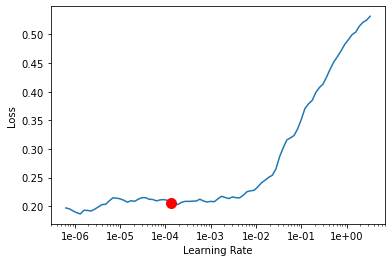

In [13]:
learn.recorder.plot(suggestion=True)

In [14]:
learn.fit_one_cycle(3,2e-4)

epoch,train_loss,valid_loss,mean_absolute_error,explained_variance,r2_score,time
0,0.137450,0.731005,44.708588,-12.154076,-13.101027,1:04:46
1,0.068081,0.727063,43.826717,-8.136429,-13.021120,1:06:14
2,0.062564,0.727063,43.826717,-8.136429,-13.021120,1:06:49


In [15]:
learn.export()

Without augmentation:
Weighted normalized absolute error (Valid): 0.8312325477600098
NAE age (Valid): 0.7598637938499451
NAE domain1_var1 (Valid): 0.7688924670219421
NAE domain1_var2 (Valid): 0.6783841848373413
NAE domain2_var1 (Valid): 1.0
NAE domain2_var2 (Valid): 1.0


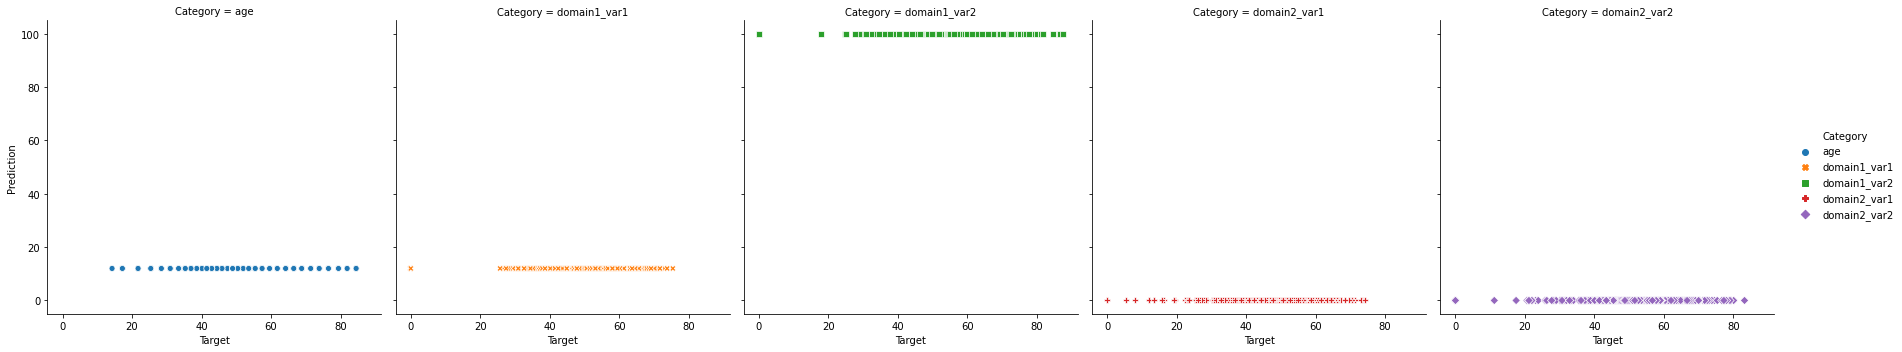

In [16]:
# val
yv, yv_truth= learn.get_preds(ds_type=DatasetType.Valid)
#yt, yt_truth= learn.get_preds(ds_type=DatasetType.Train)

print(f'Without augmentation:')
print(f'Weighted normalized absolute error (Valid): {weighted_nae(yv,yv_truth)[-1]}')
for i, dv in enumerate(DEP_VAR):
    print(f'NAE {dv} (Valid): {weighted_nae(yv,yv_truth)[i]}')
plot_diff(yv, yv_truth)